<a href="https://colab.research.google.com/github/mshilpaa/EVA4/blob/master/Session%2015/others/dice_ssim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import sys
folder = '/content/gdrive/My Drive/eva_files'
sys.path.append(folder)

In [0]:
!pip install -r '/content/gdrive/My Drive/eva_files/requirements.txt'

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-1gfz7ob2
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-1gfz7ob2
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65038 sha256=4fbb16173151e541f86f443a3aebbc3c2debe45ec8f9705921dda30e602002ec
  Stored in directory: /tmp/pip-ephem-wheel-cache-tv6cva5h/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations


In [0]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-pe2ky1bd
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-pe2ky1bd
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65038 sha256=89fe6de94b5bfbd3ad19c138adf7e1a4f402f8cd5595bb4288b531ba6aa53452
  Stored in directory: /tmp/pip-ephem-wheel-cache-w4o5yo7e/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.5
    Uninstalling albumentations-0.4.5:
      Successfully uninstalled albumentations-0.4.5


In [0]:
import customdata_loading
import data_load
import training_testing_losses
import dnn_architecture
import show_images

In [0]:
%load_ext tensorboard
%load_ext memory_profiler

In [0]:
import os
from zipfile import ZipFile 
import torch
import numpy as np
from PIL import Image
from matplotlib.image import imread
import matplotlib.pyplot as plt
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from kornia import losses

In [0]:
import albumentations as A
import albumentations.pytorch as AP
# from torch.utils.data import random_split
mean =  (0.65830478,0.61511271, 0.5740604 )
std = (0.24408717, 0.2542491, 0.26870159)
	
train_transform = A.Compose(
    [ 
    #  A.ToGray( p=1.0),
     A.Resize(64, 64, interpolation=1, always_apply=True, p=1), 
     A.Cutout(num_holes=4, max_h_size=16,max_w_size = 16,p=1,fill_value=0.6*255), 
     A.Normalize(mean=mean, std=std),
     AP.ToTensor()        
             ])
            
test_transform = A.Compose(
    [ 
     A.Resize(64, 64, interpolation=1, always_apply=True, p=1),
     AP.ToTensor()        
             ])


train_mask_transform =  A.Compose(
    [ 
     A.Resize(64, 64, interpolation=1, always_apply=True, p=1),
    #  A.Normalize(mean=(0.04608837),std=(0.20544916)),
     AP.ToTensor()        
             ])

train_depth_transform =  A.Compose(
    [ 
     A.Resize(64, 64, interpolation=1, always_apply=True, p=1),
    #  A.Normalize(mean=(0.50911522)	,std=(0.28174302)),
     AP.ToTensor()        
             ])

test_target_transform =  A.Compose(
    [ 
     A.Resize(64, 64, interpolation=1, always_apply=True, p=1),
     AP.ToTensor()        
             ])




In [0]:
train_set,test_set = customdata_loading.form_data(unzip=False,length = 80000,
                                                  train_transform=train_transform ,
                                                  train_mask_transform=train_mask_transform,
                                                  train_depth_transform=train_depth_transform, 
                                                  test_transform=test_transform ,
                                                  test_mask_transform=test_target_transform, 
                                                  test_depth_transform=test_target_transform)

Files already downloaded
Forming the dataset
Done!


In [0]:
print(len(train_set))
print(len(test_set))

56000
24000


In [0]:
trainloader,testloader = data_load.load(train_set,test_set,train_batch_size=128,test_batch_size=32)

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = dnn_architecture.Unet_Resnet().to(device)

cuda


In [0]:
from torchsummary import summary

In [0]:
summary(model, input_size=(6, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,456
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          36,864
       BatchNorm2d-5           [-1, 64, 64, 64]             128
              ReLU-6           [-1, 64, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]          36,864
            Conv2d-8           [-1, 64, 64, 64]           4,096
      Resnet_Block-9           [-1, 64, 64, 64]               0
           Conv2d-10          [-1, 128, 32, 32]          73,728
       Downsample-11          [-1, 128, 32, 32]               0
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
           Conv2d-14          [-1, 128,

In [0]:
from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter(flush_secs=5)
bg,fgbg,mask,depth = next(iter(trainloader))
data = torch.cat((bg,fgbg),1).to(device)
tb.add_graph(model,data)
tb.close()

In [0]:
%tensorboard --logdir=runs 

Reusing TensorBoard on port 6006 (pid 525), started 0:04:36 ago. (Use '!kill 525' to kill it.)

<IPython.core.display.Javascript object>

In [0]:
import torch.optim as optim
from torch.optim import lr_scheduler
from kornia import losses

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Unet_Resnet().to(device)

cuda


In [0]:
# criterion1 = nn.BCEWithLogitsLoss()
criterion1 = training_testing_losses.DiceLoss()
# criterion1 = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
criterion1 = nn.SmoothL1Loss(size_average=None, reduce=None, reduction='mean')
# criterion1 = losses.SSIM(window_size=3, reduction= 'mean')
criterion2 = losses.SSIM(window_size=3, reduction= 'mean')
# criterion2 = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
schedular = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, last_epoch=-1)
# optimizer = optim.Adam(model.parameters(), lr=0.01, eps=1e-08, weight_decay=0.9, amsgrad=False)
# schedular = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=False, 
#                                            threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

In [0]:

stats = {}
stats['mask_loss']= []
stats['depth_loss']=[]
stats['train_loss']= []
stats['mask_iou']= []
stats['ssim_index']= []

# path to save model
path = '/content/gdrive/My Drive/model_dice_ssim.pt'
trainer  = training_testing_losses.Train_model(stats)
for epoch in range(20):
  stats,mask,depth,mask_pred, depth_pred = trainer.train(model, device, trainloader, optimizer, criterion1,criterion2,epoch,path=path)
  schedular.step()


Epoch= 1 LR= 0.01 Mask Loss=0.222677081823349 Depth Loss=0.12611670792102814 Loss=0.17439690232276917 Batch_id=437: 100%|██████████| 438/438 [03:45<00:00,  1.94it/s]
Epoch= 2 LR= 0.01 Mask Loss=0.1998170018196106 Depth Loss=0.10603561997413635 Loss=0.15292631089687347 Batch_id=437: 100%|██████████| 438/438 [03:45<00:00,  1.94it/s]
Epoch= 3 LR= 0.01 Mask Loss=0.1918501853942871 Depth Loss=0.09444868564605713 Loss=0.14314943552017212 Batch_id=437: 100%|██████████| 438/438 [03:45<00:00,  1.94it/s]
Epoch= 4 LR= 0.01 Mask Loss=0.20511896908283234 Depth Loss=0.08927839994430542 Loss=0.14719867706298828 Batch_id=437: 100%|██████████| 438/438 [03:45<00:00,  1.94it/s]
Epoch= 5 LR= 0.01 Mask Loss=0.17822813987731934 Depth Loss=0.0842382162809372 Loss=0.13123318552970886 Batch_id=437: 100%|██████████| 438/438 [03:45<00:00,  1.94it/s]
Epoch= 6 LR= 0.01 Mask Loss=0.19532833993434906 Depth Loss=0.07744883745908737 Loss=0.13638858497142792 Batch_id=437: 100%|██████████| 438/438 [03:45<00:00,  1.94it/

In [0]:
len(stats['mask_loss'])

18

In [0]:
best_loss1 = trainer.__dict__['train_loss'][-1]
stats['mask_loss'].extend(trainer.__dict__['mask_loss'])
stats['depth_loss'].extend(trainer.__dict__['depth_loss'])
stats['train_loss'].extend(trainer.__dict__['train_loss'])
stats['mask_iou'].extend(trainer.__dict__['mask_ious'])
stats['ssim_index'].extend(trainer.__dict__['ssim_indices'])

save_model(epoch = 20, model = model.state_dict(), optimizer = optimizer.state_dict(), stats = stats,
            best_loss1 =best_loss1,path= '/content/gdrive/My Drive/model_dice_ssim.pt')

In [0]:
# test on test images
test_bg,test_fgbg,test_mask,test_depth = next(iter(trainloader))
test_data = torch.cat((test_fgbg,test_bg),1)
test_data = test_data.to(device)
test_predMask,test_predDepth = model(test_data)

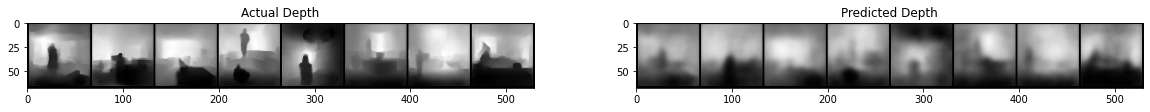

In [0]:
show_images.show_unet_images(test_depth,test_predDepth,title='Depth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


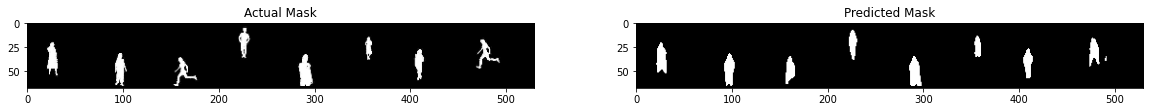

In [0]:
show_images.show_unet_images(test_mask,test_predMask,title='Mask')